### Import packages 

In [1]:
import warnings

import matplotlib.pyplot as plt

from model import DeepModel
from utils import get_users_and_movies_count, get_ratings_and_links_merged
from sklearn.model_selection import KFold
import numpy
from model import DeepModel
    
warnings.filterwarnings('ignore')
% matplotlib inline


Using TensorFlow backend.


### Get ratings data from file

In [2]:
ratings_and_links = get_ratings_and_links_merged()

print ratings_and_links.shape
ratings_and_links.head()


Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/ratings.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv
9066 of the 9066 movies are rated.
671 of the 671 users rate at least one movie.
(100004, 6)


userId  movieId rating   timestamp   imdbId tmdbId
0       0     3879    2.5  1260759144  0112792   9909
1       0      235    3.0  1260759179  0033563  11360
2       0     4293    3.0  1260759182  0117665    819
3       0     1898    2.0  1260759185  0082340   1103
4       0     2746    4.0  1260759205  0095765  11216

### Transform user IDs and movie IDs to have values from range (0, N-1)

In [3]:
n_users, n_movies = get_users_and_movies_count(ratings_and_links)

Number of users: 671
Number of rated movies: 9066


**Train test split**
We'll now split our dataset of 100k ratings into train (containing 80k ratings) and test (containing 20k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

### Using neural network

In [4]:
LATENT_FACTORS_USERS = 120
LATENT_FACTORS_MOVIES = 120
LEARNING_RATE = .005
DROPOUT = .2
TEST_SIZE = .1
RNG_SEED = 1446557

In [5]:
def init_model(user_factors=LATENT_FACTORS_USERS, movie_factors=LATENT_FACTORS_MOVIES):
    return DeepModel(n_users, n_movies, user_factors, movie_factors, DROPOUT)


model_SINGLE = init_model() \
    .add_dense_layer(120) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)


model_DEEP1 = init_model() \
    .add_dense_layer(120) \
    .add_dense_layer(60) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)
    
model_DEEP2 = init_model(200, 150) \
    .add_dense_layer(350) \
    .add_dense_layer(150) \
    .add_dense_layer(60) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)
    
model_DEEP3 = init_model(80, 200) \
    .add_dense_layer(280) \
    .add_dense_layer(100) \
    .add_dense_layer(30) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)

model_DEEP4 = init_model(40, 40) \
    .add_dense_layer(80) \
    .add_dense_layer(20) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)

In [6]:
id_to_model = {
    'SINGLE': model_SINGLE,
    'DEEP1': model_DEEP1,
    'DEEP2': model_DEEP2,
    'DEEP3': model_DEEP3,
    'DEEP4': model_DEEP4
}

In [22]:
def k_fold(model_id):
    kf = KFold(n_splits=3, shuffle=True, random_state=RNG_SEED)
    cvscores = []
    idx = 1

    for train, test in kf.split(ratings_and_links):
        train_data = ratings_and_links[ratings_and_links.index.isin(train)]
        test_data = ratings_and_links[ratings_and_links.index.isin(test)]

        model = id_to_model[model_id]
        print 'Starting %d fold against model %s' % (idx, model_id)

        model.fit(train_data, 
                  epochs=20, 
                  override_checkpoint=False,
                  validation_split=0.,
                  checkpoint_id='checkpoints/%s_%d' % (model_id, idx))

        scores = model.model.evaluate([test_data.userId, test_data.movieId], test_data.rating, verbose=1)
        print("%s: %.4f" % (model.model.metrics_names, scores))
        cvscores.append(scores)
        idx += 1
    
    print("%s: %.4f (+/- %.2f%%)" % (model_id, numpy.mean(cvscores), numpy.std(cvscores)))
    return cvscores


In [33]:
scores2 = k_fold('DEEP2')
# single: 86.25, +- 7.68
# DEEP1: 86.30% (+/- 3.36%)
# DEEP3: 0.8319 (+/- 0.04%)

Starting 1 fold against model DEEP2
Epoch 1/20
66669/66669 [==============================] - 33s 490us/step - loss: 1.2158
Epoch 2/20
66669/66669 [==============================] - 34s 512us/step - loss: 0.9192
Epoch 3/20
66669/66669 [==============================] - 38s 572us/step - loss: 0.9478
Epoch 4/20
66669/66669 [==============================] - 41s 618us/step - loss: 0.9660
Epoch 5/20
66669/66669 [==============================] - 39s 581us/step - loss: 0.9774
Epoch 6/20
66669/66669 [==============================] - 38s 569us/step - loss: 0.9837
Epoch 7/20
66669/66669 [==============================] - 35s 524us/step - loss: 0.9800
Epoch 8/20
66669/66669 [==============================] - 34s 503us/step - loss: 0.9838
Epoch 9/20
66669/66669 [==============================] - 34s 503us/step - loss: 0.9865
Epoch 10/20
66669/66669 [==============================] - 34s 506us/step - loss: 0.9957
Epoch 11/20
66669/66669 [==============================] - 34s 510us/step - loss: 0

In [83]:
model_id = 'DEEP4'
history = id_to_model[model_id].history

min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['loss']))
print 'Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss))

Minimum RMSE at epoch 16 = 0.8479


In [28]:
import math, pandas as pd
def plot_models_loss(id_to_model,training=True, validation=False):
    loss_dict = {}
    epoch_max = -1
    for checkpoint_id, model in id_to_model.iteritems(): 
        epoch_max = max(max(model.history.epoch), epoch_max)
        if training:
            loss_dict['%s_training' % checkpoint_id] = [math.sqrt(loss) for loss in model.history.history['loss']]
        if validation:
            loss_dict['%s_validation' % checkpoint_id] = [math.sqrt(loss) for loss in model.history.history['val_loss']]
    loss_dict['epoch'] = [i + 1 for i in xrange(epoch_max + 1)]

    loss = pd.DataFrame(loss_dict)
    loss_reindexed = loss.ix[:, :]
    xticks = list(loss_reindexed.epoch)
    
#     import scipy
#     import numpy as np
    
#     def gauss(x, *p):
#         a, b, c, d = p
#         y = a*np.exp(-np.power((x - b), 2.)/(2. * c**2.)) + d

#         return y
    
#     p_initial = [1.0, 0.0, 0.1, 0.0]
#     coeffs, matcov = scipy.optimize.curve_fit(gauss, map(float, loss_reindexed.epoch), 
#                                               loss_reindexed['%s_validation' % checkpoint_id],
#                                               p0=p_initial)
#     loss_reindexed['fit'] = gauss(loss_reindexed.epoch, *coeffs)
    
    
    ax = loss_reindexed.plot(x='epoch', grid=True, xticks=xticks)
    lgd = ax.legend(bbox_to_anchor=(1.5, .75))
    ax.set_ylabel("root mean squared error")
    ax.set_ylim([0.8, 1.1])
    
    return ax.figure, lgd

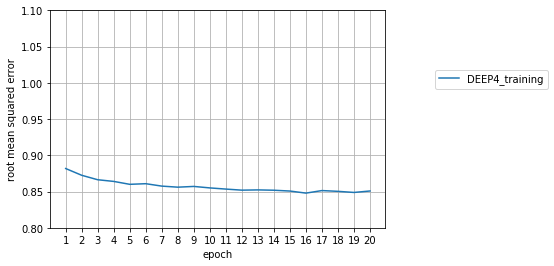

In [58]:
for k, v in {model_id: id_to_model['DEEP4']}.iteritems():
    figure, lgd = plot_models_loss({k: v})
#     figure.savefig(k + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plot_models_loss(id_to_model, training=False).figure.savefig('val_compare.jpg')
# plot_models_loss(id_to_model, validation=False).figure.savefig('training_compare.jpg')

In [37]:
from utils import get_column
Users = get_column(ratings_and_links, 'userId')
Movies = get_column(ratings_and_links, 'movieId')

userId: [  0   0   0 ..., 635 635 635], shape = (100004,)
movieId: [3879  235 4293 ..., 5500 5958 6169], shape = (100004,)


In [204]:
from utils import get_all_data
ratings, links, movies = get_all_data()

ratings_and_links = pd.merge(ratings, links, on='movieId', how='left')
all_data = pd.merge(ratings_and_links, movies, on='movieId', how='left')
all_data = all_data.loc[all_data['imdbId'].notnull()]


all_data['movieId'] = ratings_and_links['imdbId']
all_data.userId = ratings_and_links.userId.astype('category').cat.codes.values
all_data.movieId = ratings_and_links.movieId.astype('category').cat.codes.values


Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/ratings.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/links.csv
Getting data from /Users/patrykkowalczyk/Desktop/ml-latest-small/movies.csv


In [132]:
movie_id_to_title = {row.movieId: row.title for row in all_data.itertuples()}
colab_model = id_to_model['DEEP4']

In [147]:
def get_movies_rated_by(user_id):
    movie_ids = all_data.loc[all_data['userId'] == user_id].movieId.unique()
    id_to_title = {k: v for k, v in movie_id_to_title.iteritems() if k in movie_ids}
    return movie_ids, id_to_title

def get_movies_not_rated_by(user_id):
    rated_movies, _ = get_movies_rated_by(user_id)
    return [m_id for m_id in xrange(0, n_movies) if m_id not in rated_movies]

def get_all_movie_recommendations(user_id):
    movies = get_movies_not_rated_by(user_id)
    movies_and_rates = sorted(map(lambda m: [m, colab_model.rate(user_id, m)], movies), 
                              key=lambda x:x[1], 
                              reverse=True)
    return map(lambda x: x[0], movies_and_rates)

def get_movie_recommendations(user_id, rec_count=5):
    return get_all_movie_recommendations(user_id)[:rec_count]

In [150]:
recs = get_movie_recommendations(0, 5)

In [151]:
recs

[3707, 6876, 2842, 4605, 7573]

In [152]:
movies, titles = get_movies_rated_by(0)

In [193]:
colab_model = DeepModel(n_users, n_movies, 40, 40, DROPOUT) \
    .add_dense_layer(80) \
    .add_dense_layer(20) \
    .add_relu_dense_layer(1, 'Activation', None) \
    .build(LEARNING_RATE)
    
colab_model_id = 'DEEP4_FINAL_2'
print 'Training model(ID = %s)' % colab_model_id
colab_model.fit(shuffled_ratings, epochs=40, override_checkpoint=True, checkpoint_id=colab_model_id, early_stop_patience=2)

Training model(ID = DEEP4_FINAL_2)
Train on 90003 samples, validate on 10001 samples
Epoch 1/40
90003/90003 [==============================] - 12s 130us/step - loss: 1.0711 - val_loss: 0.8379
Epoch 2/40
90003/90003 [==============================] - 11s 127us/step - loss: 0.8274 - val_loss: 0.8025
Epoch 3/40
90003/90003 [==============================] - 12s 131us/step - loss: 0.7974 - val_loss: 0.8115
Epoch 4/40
90003/90003 [==============================] - 12s 133us/step - loss: 0.7845 - val_loss: 0.8082


In [154]:
titles

{106: 'Dumbo (1941)',
 242: 'Sleepers (1996)',
 488: 'Escape from New York (1981)',
 608: 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
 767: 'Deer Hunter, The (1978)',
 819: 'Ben-Hur (1959)',
 830: 'Gandhi (1982)',
 931: "Dracula (Bram Stoker's Dracula) (1992)",
 940: 'Cape Fear (1991)',
 1004: 'Star Trek: The Motion Picture (1979)',
 1063: 'Beavis and Butt-Head Do America (1996)',
 1636: 'French Connection, The (1971)',
 1802: 'Tron (1982)',
 1849: 'Gods Must Be Crazy, The (1980)',
 1888: 'Willow (1988)',
 1969: 'Antz (1998)',
 2134: 'Fly, The (1986)',
 2931: 'Time Bandits (1981)',
 3079: 'Dangerous Minds (1995)',
 3788: 'Blazing Saddles (1974)'}

In [155]:
{r: movie_id_to_title[r] for r in recs}

{2842: 'Excalibur (1981)',
 3707: 'Battlefield Earth (2000)',
 4605: 'Big Boss, The (Fists of Fury) (Tang shan da xiong) (1971)',
 6876: 'Jungle Book (1942)',
 7573: 'Girl Who Played with Fire, The (Flickan som lekte med elden) (2009)'}

In [157]:
user_to_movies_rated = {}
for u_id in xrange(n_users):
    user_to_movies_rated[u_id] = get_movies_rated_by(u_id)[0] 
    if u_id % 50 == 0:
        print 'Found movies for %d users' % (u_id + 1)

Found movies for 1 users
Found movies for 51 users
Found movies for 101 users
Found movies for 151 users
Found movies for 201 users
Found movies for 251 users
Found movies for 301 users
Found movies for 351 users
Found movies for 401 users
Found movies for 451 users
Found movies for 501 users
Found movies for 551 users
Found movies for 601 users
Found movies for 651 users


In [158]:
user_to_movies_rated[0]

array([3079,  106,  242,  488,  608,  767,  819,  830,  931,  940, 1004,
       1063, 1636, 1802, 1849, 1888, 1969, 2134, 2931, 3788])

In [160]:
users_by_rate = sorted([[k, len(v)] for k,v in user_to_movies_rated.iteritems()], key=lambda x: x[1], reverse=True)

In [161]:
users_by_rate[:10]

[[497, 2391],
 [516, 1868],
 [583, 1735],
 [56, 1700],
 [642, 1610],
 [392, 1340],
 [409, 1291],
 [312, 1063],
 [236, 1019],
 [223, 1011]]

In [196]:
u_to_recs = {u[0]: get_movie_recommendations(u[0], 5) for u in users_by_rate[:10]}

In [197]:
for u,recs in u_to_recs.iteritems():
    print u, recs

    

642 [3381, 2999, 6701, 4407, 1620]
516 [3381, 2999, 6701, 4407, 1620]
583 [3381, 2999, 6701, 4407, 1620]
392 [2999, 6701, 1620, 3069, 7480]
236 [3381, 2999, 6701, 1620, 3069]
497 [3069, 7480, 6825, 2889, 2729]
56 [3381, 2999, 6701, 4407, 1620]
409 [2999, 6701, 4407, 3069, 7480]
223 [3381, 6701, 1620, 3069, 7480]
312 [3381, 2999, 6701, 4407, 1620]


In [199]:
{r: movie_id_to_title[r] for r in u_to_recs[223]}

{1620: 'Best Years of Our Lives, The (1946)',
 3069: 'Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)',
 3381: 'Kid, The (1921)',
 6701: 'Dear Zachary: A Letter to a Son About His Father (2008)',
 7480: "Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)"}

In [203]:
all_data.loc[all_data['movieId'] == 2999]


userId  movieId rating   timestamp   imdbId tmdbId  \
5639      223     2999    5.0  1014613565  0050371  21849   
32216     148     2999    5.0   955092600  0050371  21849   
53605     319     2999    5.0   974670360  0050371  21849   
79171     497     2999    5.0   974777753  0050371  21849   

                             title genres  
5639   Face in the Crowd, A (1957)  Drama  
32216  Face in the Crowd, A (1957)  Drama  
53605  Face in the Crowd, A (1957)  Drama  
79171  Face in the Crowd, A (1957)  Drama

In [194]:
rates = [colab_model.rate(i, 6876) for i in xrange(n_users)]

In [195]:
sum(rates) / len(rates)

3.429283033184785

In [192]:
RNG_SEED = 1446557
# train, test = train_test_split(merged, test_size=TEST_SIZE)

shuffled_ratings = all_data.sample(frac=1., random_state=RNG_SEED)